In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import torchvision.transforms.functional as tf
import albumentations as A
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
img_dir="C:\\Users\\hp\\Desktop\\demo\\images"
annot_dir="C:\\Users\\hp\\Desktop\\demo\\annotation"

#label 0 is fixed for background
classes=["background","pothole"]

num_classes=2
device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=4
epochs=40
learning_rate=3e-5

model_weights_file="model.pth"

threshold=0.25
iou_threshold=0.75

In [4]:
def parse_xml(annot_path):
    tree=ET.parse(annot_path)
    root=tree.getroot()
    
    width=int(root.find("size").find("width").text)
    height=int(root.find("size").find("height").text)
    boxes=[]
    
    for obj in root.findall("object"):
        bbox=obj.find("bndbox")
        xmin=int(bbox.find("xmin").text)
        ymin=int(bbox.find("ymin").text)
        xmax=int(bbox.find("xmax").text)
        ymax=int(bbox.find("ymax").text)
        
        boxes.append([xmin,ymin,xmax,ymax])
        
    return boxes,height,width

In [5]:
ignore_img=[]
for annot_name in os.listdir(annot_dir):
    img_name=annot_name[:-4]+".png"
    annot_path=os.path.join(annot_dir,annot_name)
    boxes,height,width=parse_xml(annot_path)
    
    for box in boxes:
        if box[0]<0 or box[0]>=box[2] or box[2]>width:
            print(box[0],box[2],width)
            print("x",annot_name)
            print("*"*50)
            ignore_img.append(img_name)
        elif box[1]<0 or box[1]>=box[3] or box[3]>height:
            print(box[1],box[3],height)
            print("y",file_name)
            print("*"*50)
            ignore_img.append(img_name)

312 401 400
x potholes214.xml
**************************************************
273 273 400
x potholes58.xml
**************************************************


In [6]:
ignore_img

['potholes214.png', 'potholes58.png']

In [7]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=15,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(height=480,width=480)],
                          bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                   label_fields=["labels"]))
                           
val_transform=A.Compose([A.Resize(height=480,width=480)],
                        bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                 label_fields=["labels"]))

In [8]:
class PotholeDetection(Dataset):
    def __init__(self,img_dir,annot_dir,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.annot_dir=annot_dir
        self.img_list=sorted([img for img in os.listdir(self.img_dir) 
                              if img not in ignore_img])
        self.transform=transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        img_name=self.img_list[idx]
        img_path=os.path.join(self.img_dir,img_name)
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        annot_name=img_name[:-4]+".xml"
        annot_path=os.path.join(self.annot_dir,annot_name)
        boxes,height,width=parse_xml(annot_path)
        labels=[1]*len(boxes)
        
        if self.transform is not None:
            transformed=self.transform(image=img,bboxes=boxes,labels=labels)
            img=transformed["image"]
            boxes=transformed["bboxes"]
            labels=transformed["labels"]
        
        if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]
                
        img=img/255
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)
            
        return img,target

In [9]:
train_ds=PotholeDetection(img_dir,annot_dir,train_transform)
val_ds=PotholeDetection(img_dir,annot_dir,val_transform)

In [10]:
from torch.utils.data import Subset

In [11]:
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(0.85*len(train_ds))]
val_idx=idxs[int(0.85*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)
len(val_ds)

100

In [12]:
def show_bbox(img,target,color=(0,255,0)):
    img=np.transpose(img.cpu().numpy(),(1,2,0))
    boxes=target["boxes"].cpu().numpy().astype("int")
    labels=target["labels"].cpu().numpy()
    img=img.copy()
    for i,box in enumerate(boxes):
        idx=int(labels[i])
        text=classes[idx]

        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
        
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


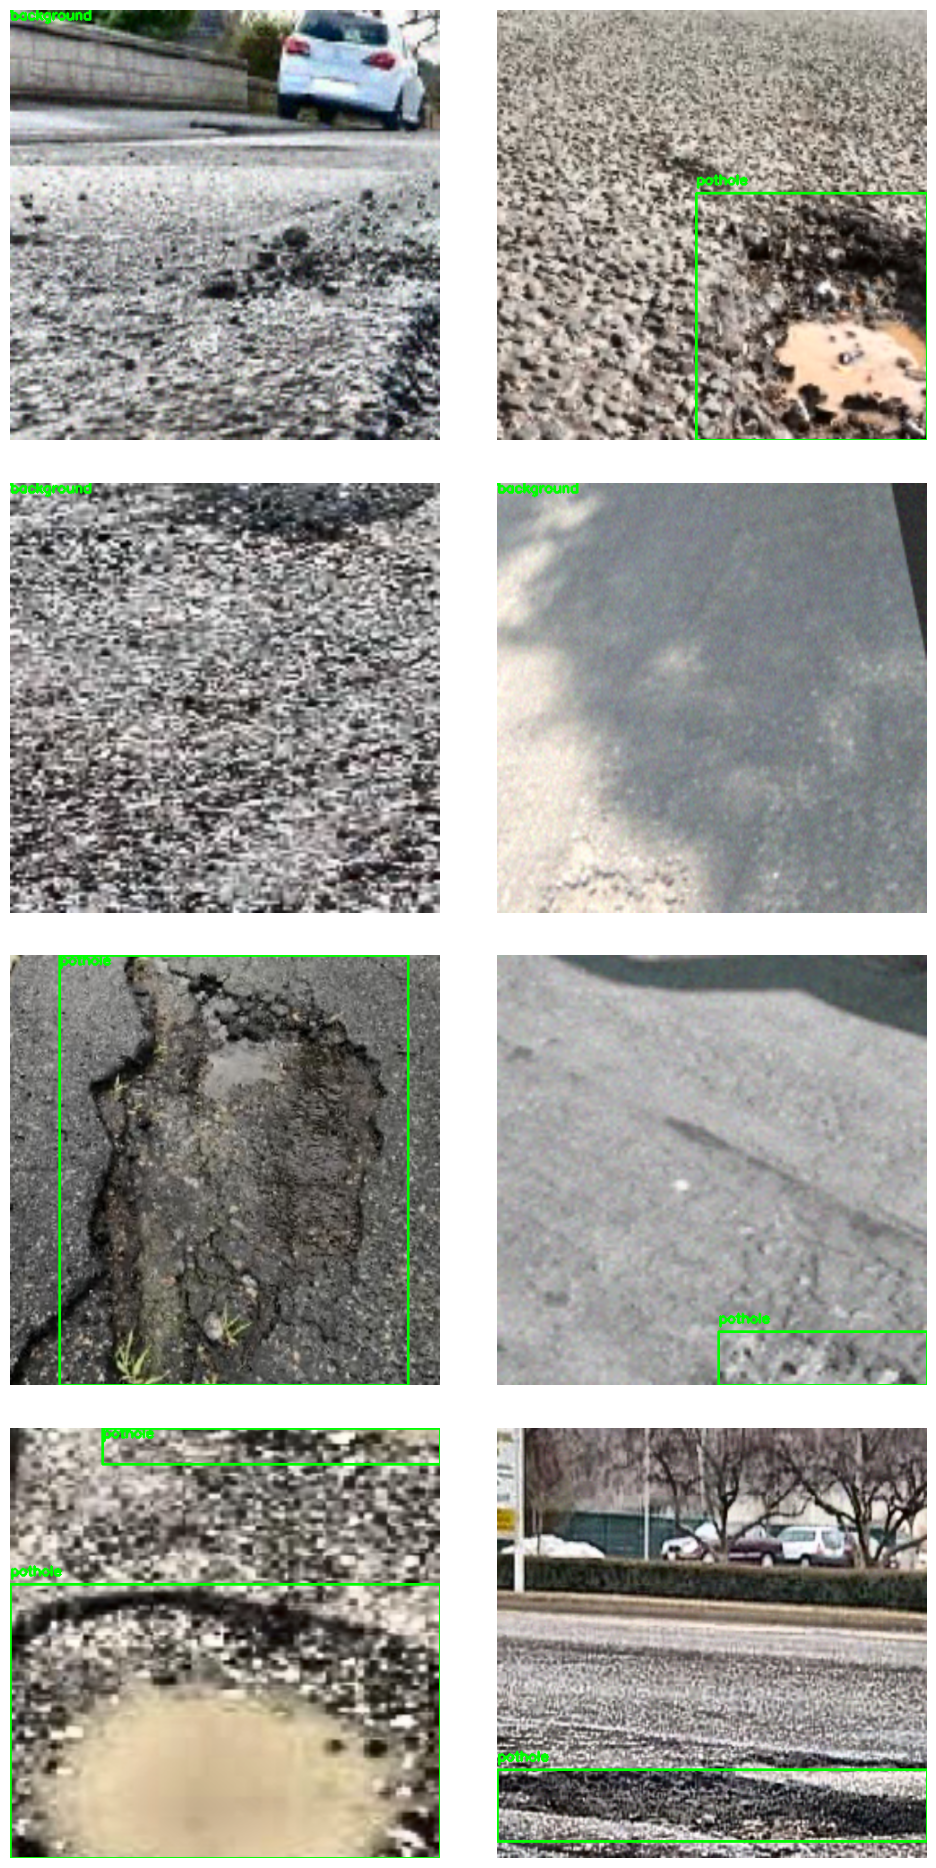

In [13]:
fig,axes=plt.subplots(4,2,figsize=(12,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

idxs=np.random.choice(range(len(train_ds)),8)
for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    output_img=show_bbox(img,target)
    ax[i].imshow(output_img)
    ax[i].axis("off")

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=0,
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=0,
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

In [16]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [17]:
for params in model.backbone.features.parameters():
    params.requires_grad=False
    
parameters=[params for params in model.parameters() if params.requires_grad]

optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)

In [18]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [19]:
model_weights_pth="C:\\Users\\hp\\Desktop\\Final project\\Pothloe_detection\\dataset\\weights\\model.pth"
model=ssd300_vgg16()

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.load_state_dict(torch.load(model_weights_pth,map_location=device))
model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [20]:
def preprocess_bbox(prediction):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

In [21]:
# metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
# metric.to(device)

# model.eval()
# with torch.no_grad():
#     for imgs,targets in val_dl:
#         imgs=[img.to(device) for img in imgs]
#         targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
#         predictions=model(imgs)
        
#         results=[]
#         for prediction in predictions:
#             results.append(preprocess_bbox(prediction))
        
#         metric.update(results,targets)
        
# results=metric.compute()

In [22]:
# mean_ap=results["map"].item()
# mean_ap_50=results["map_50"].item()
# mean_ap_75=results["map_75"].item()

# print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
# print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
# print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


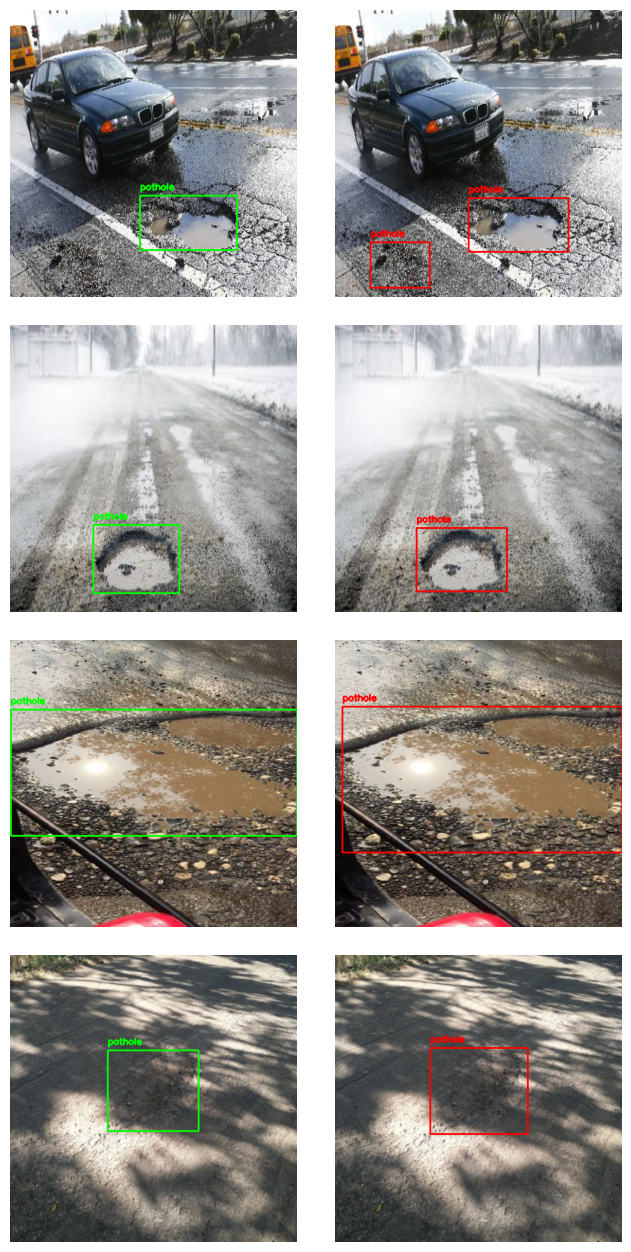

In [23]:

fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(val_dl))
model.eval()
with torch.no_grad():
    output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    prediction=output[idx]
    
    #real bounding boxes
    output_img=show_bbox(img,targets[idx],color=(0,255,0));
    axes[i,0].imshow(output_img);
    axes[i,0].axis("off");
    
    #predicted bounding box
    predict=preprocess_bbox(prediction)
    output_img=show_bbox(img,predict,color=(255,0,0));
    axes[i,1].imshow(output_img);
    axes[i,1].axis("off");
    
plt.savefig("4.png")

In [24]:
# video_path="C:\\Users\\BHARATH\\OneDrive\\Desktop\\pothole_detection\\pothole\\input\\pothole.mp4"
# video_out_path="C:\\Users\\BHARATH\\OneDrive\\Desktop\\pothole_detection\\pothole\\input\\output_video.mp4"

# cap=cv2.VideoCapture(video_path)
# if (cap.isOpened() == False):
#     print('Error while trying to read video. Please check path again')
    
# # define codec and create VideoWriter object 
# out=cv2.VideoWriter(video_out_path, 
#                     cv2.VideoWriter_fourcc(*'XVID'), 30, 
#                     (480,480))

# model=model.eval()

# # read until end of video
# while(cap.isOpened()):
#     # capture each frame of the video
#     ret, frame=cap.read()
#     if ret==True:
#         with torch.no_grad():
#             # get predictions for the current frame
#             frame=cv2.resize(frame,(480,480))
#             frame=frame/255
#             frame=np.transpose(frame,(2,0,1))
#             frame=torch.as_tensor(frame,dtype=torch.float32)
#             frame=frame.to(device)
#             output=model([frame])
#             predict=preprocess_bbox(output[0])
#             output_img=show_bbox(frame,predict)
#             output_img=(output_img*255).astype(np.uint8)
#             out.write(output_img)
#     else:
#         break
        
# # release VideoCapture()
# out.release()
# cap.release()

In [25]:
import cv2
import torch

# Initialize the camera
cap = cv2.VideoCapture(0)  # Change the parameter to 1 if you want to use an external camera


# Define the function to preprocess the input frame
def preprocess_frame(frame):
    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Resize the frame to match the input size of your model
    frame_resized = cv2.resize(frame_rgb, (480, 480))
    # Convert the resized frame to PyTorch tensor
    frame_tensor = torch.tensor(frame_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0
    return frame_tensor.unsqueeze(0)  # Add a batch dimension

# Define the function to draw bounding boxes on the frame
def draw_boxes(frame, prediction):
    for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
        # Convert PyTorch tensor to NumPy array
        box = box.cpu().numpy().astype(int)
        # Draw bounding box
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        # Add label and score
        cv2.putText(frame, f'{classes[label]}: {score:.2f}', (box[0], box[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Process video frames
while True:
    ret, frame = cap.read()  # Read frame from the camera
    
    if not ret:
        print("Error: Couldn't read frame from the camera")
        break
    
    # Preprocess the frame
    frame_tensor = preprocess_frame(frame)
    
    # Run inference on the frame
    with torch.no_grad():
        model.eval()
        output = model(frame_tensor)
    
    # Process the model's output to get bounding boxes
    prediction = preprocess_bbox(output[0])
    
    # Draw bounding boxes on the frame
    draw_boxes(frame, prediction)
    
    # Display the frame with bounding boxes
    cv2.imshow('Pothole Detection', frame)
    
    # Press 'q' to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()
